## make brand2vect
-----
-----

### step 1. make trainset

#### import data

In [6]:
%matplotlib inline

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_path = "/workspace/dataset/"

In [7]:
df = pd.read_csv(data_path + "train_sample.csv")
print(df.shape)
df.head()

(8134818, 11)


,bcateid,brand,dcateid,maker,mcateid,model,pid,price,product,scateid,updttm
0,1,퍼즐라이프,-1,상품상세설명 참조,1,퍼즐라이프 직소퍼즐 바다거북의 여행,b'O4486751463',16520,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),2,b'20180227091029'
1,3,바보사랑,-1,MORY|해당없음,3,아이폰6S/6S+ tree farm101 - 다이어리케이스|아이폰6S/6S+,b'P3307178849',20370,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][...,4,b'20180429085019'
2,5,크리비아,-1,NaN,5,크리비아 기모 3부 속바지 GLG4314P,b'R4424255515',-1,크리비아 기모 3부 속바지 GLG4314P,6,b'20180426102314'
3,7,잭앤질,-1,㈜크리스패션,7,[잭앤질] 남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,b'F3334315393',16280,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,8,b'20180422084512'
4,10,NaN,-1,기타,9,SD코드프리혈당시험지[50매],b'N731678492',-1,코드프리혈당시험지50매/코드프리시험지/최장유효기간,11,b'20180424071623'


#### make new dict

In [8]:
# exception_word_list = ["참조", "없음", "표기", "별도", "상세", "자체", "불명", "미입력", "공개불가"]
# exception_tag_list = ["기타", "", "."]

# def check_valid(keyword):
#     if keyword is np.nan:
#         return False
#     else:
#         if any(exception in keyword for exception in exception_word_list):
#             return False
#         elif keyword in exception_tag_list:
#             return False
#         else:
#             return True

# def get_trimed_tag(brand, maker):
#     brand_valid = check_valid(brand)
#     maker_valid = check_valid(maker)
#     if brand_valid:
#         return brand
#     else:
#         if maker_valid:
#             return maker
#     return "-1"

# df['tag'] = df.apply(lambda x: get_trimed_tag(x['brand'], x['maker']), axis=1)

In [9]:
# tag_list = df['tag'].value_counts().index
# tag_dict = {}

# idx = 1
# for tag in tag_list:
#     tag_dict[tag] = idx
#     idx = idx + 1

In [10]:
# len(tag_dict)

In [11]:
# # save
# with open('b2v_dict.pickle', 'wb') as f:
#     pickle.dump(tag_dict, f, pickle.HIGHEST_PROTOCOL)

#### encode to brand, maker -> tag

In [12]:
valid_tag_dict_path = "b2v_dict.pickle"
valid_tag_dict = pickle.load(open(valid_tag_dict_path, 'rb'))
exception_word_list = ["참조", "없음", "표기", "별도", "상세", "자체", "불명", "미입력", "공개불가"]
exception_tag_list = ["기타", "", "."]

def check_valid_keyword(keyword):
    if keyword is np.nan:
        return False
    else:
        if any(exception in keyword for exception in exception_word_list):
            return False
        elif keyword in exception_tag_list:
            return False
        else:
            return True

def get_encoded_tag(key):
    if key in valid_tag_dict:
        return valid_tag_dict[key]
    else:
        return valid_tag_dict["-1"]

def get_trimed_tag(brand, maker):
    brand_valid = check_valid_keyword(brand)
    maker_valid = check_valid_keyword(maker)
    if brand_valid:
        return get_encoded_tag(brand)
    else:
        if maker_valid:
            return get_encoded_tag(brand)
    return valid_tag_dict["-1"]

In [13]:
df['tag'] = df.apply(lambda x: get_trimed_tag(x['brand'], x['maker']), axis=1)

#### select features for b2v

In [14]:
df = df[['bcateid','mcateid', 'scateid', 'dcateid', 'tag']]

In [15]:
df['tag'] = df['tag'].apply(lambda x: str(x))

In [16]:
df.head()

,bcateid,mcateid,scateid,dcateid,tag
0,1,1,2,-1,701
1,3,3,4,-1,2
2,5,5,6,-1,615
3,7,7,8,-1,328
4,10,9,11,-1,1


#### make brand co-occurence vector for train_list

In [17]:
import gensim
import re

In [18]:
df = df[df['tag'] != "1"]

In [19]:
df.shape

(3804370, 5)

In [20]:
b_list = df.groupby('bcateid')['tag'].apply(lambda x: list(x.unique())).values.tolist()
train_list = [x for x in b_list if len(x) > 1]

m_list = df.groupby('mcateid')['tag'].apply(lambda x: list(x.unique())).values.tolist()
m_list = [x for x in m_list if len(x) > 1]

s_list = df.groupby('scateid')['tag'].apply(lambda x: list(x.unique())).values.tolist()
s_list = [x for x in s_list if len(x) > 1]

d_list = df.groupby('dcateid')['tag'].apply(lambda x: list(x.unique())).values.tolist()
d_list = [x for x in d_list if len(x) > 1]

In [21]:
train_list.extend(m_list)
train_list.extend(s_list)
train_list.extend(d_list)

#### train w2v model : brand2vect

In [22]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [23]:
model = gensim.models.Word2Vec(train_list, size=200, window = 3, min_count=2, workers=4, iter=15, sg=1)

2018-12-20 23:17:09,729 : INFO : collecting all words and their counts
2018-12-20 23:17:09,730 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-12-20 23:17:10,432 : INFO : collected 193194 word types from a corpus of 1685980 raw words and 4108 sentences
2018-12-20 23:17:10,433 : INFO : Loading a fresh vocabulary
2018-12-20 23:17:11,453 : INFO : effective_min_count=2 retains 193194 unique words (100% of original 193194, drops 0)
2018-12-20 23:17:11,454 : INFO : effective_min_count=2 leaves 1685980 word corpus (100% of original 1685980, drops 0)
2018-12-20 23:17:12,078 : INFO : deleting the raw counts dictionary of 193194 items
2018-12-20 23:17:12,089 : INFO : sample=0.001 downsamples 0 most-common words
2018-12-20 23:17:12,090 : INFO : downsampling leaves estimated 1685980 word corpus (100.0% of prior 1685980)
2018-12-20 23:17:12,943 : INFO : estimated required memory for 193194 words and 200 dimensions: 405707400 bytes
2018-12-20 23:17:12,944 : INFO : res

2018-12-20 23:17:54,826 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-12-20 23:17:54,843 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-12-20 23:17:54,866 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-12-20 23:17:54,915 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-12-20 23:17:54,916 : INFO : EPOCH - 8 : training on 1685980 raw words (1391558 effective words) took 5.0s, 278532 effective words/s
2018-12-20 23:17:55,932 : INFO : EPOCH 9 - PROGRESS: at 1.22% examples, 253779 words/s, in_qsize 7, out_qsize 0
2018-12-20 23:17:56,947 : INFO : EPOCH 9 - PROGRESS: at 4.94% examples, 256790 words/s, in_qsize 6, out_qsize 1
2018-12-20 23:17:57,971 : INFO : EPOCH 9 - PROGRESS: at 16.11% examples, 267762 words/s, in_qsize 8, out_qsize 0
2018-12-20 23:17:58,973 : INFO : EPOCH 9 - PROGRESS: at 33.62% examples, 273213 words/s, in_qsize 8, out_qsize 0
2018-12-20 23:17:59,871 : INFO : worker thread fi

In [71]:
model.save("b2v.model")

2018-12-20 23:42:13,729 : INFO : saving Word2Vec object under b2v.model, separately None
2018-12-20 23:42:13,730 : INFO : storing np array 'syn1neg' to b2v.model.trainables.syn1neg.npy
2018-12-20 23:42:13,894 : INFO : storing np array 'vectors' to b2v.model.wv.vectors.npy
2018-12-20 23:42:14,044 : INFO : not storing attribute vectors_norm
2018-12-20 23:42:14,045 : INFO : not storing attribute cum_table
2018-12-20 23:42:14,592 : INFO : saved b2v.model


#### validation : print most similar

In [25]:
valid_tag_dict

{'Gymboree': 81632,
 '야호컴 / 야호컴': 208550,
 '독일': 11991,
 '홀랜더': 236147,
 '스투피드': 655,
 '주)SG세계물산': 46283,
 '컴스메카': 232322,
 '제조자:JT / 수입자:JT': 205884,
 'munchkin': 71751,
 'Royal Albert': 36850,
 '초이스뮤직': 157130,
 '네 카': 168196,
 'UTLK': 191136,
 '푸르내잉크': 8496,
 '노벡스': 95933,
 '아크컴퍼니': 5198,
 '진아놀자': 206543,
 '다밋': 176433,
 '단스킨(DANSKIN)': 46115,
 '동일플라스틱': 44707,
 '국민출판사(선한청지기)': 156396,
 '주식회사인디고': 159750,
 'Fuzhou Home Broad Ar / Fuzhou Home Broad Ar': 91333,
 '일본 ZOOM': 214144,
 '대구테크노파크': 190226,
 'GMYLE': 41167,
 '디포트(DEPOT)': 61685,
 'Lizard spit': 169946,
 '태영통상 / 태영통상': 212128,
 'CMMM[센티밀리]': 130775,
 'DAVICHE[다비채]': 206082,
 'Heartisan': 192439,
 'Caravelle New York': 31102,
 '8683447': 79667,
 '엘리먼트 클리퍼 앤 프로덕트': 199192,
 'DB04/보카시초록스트로베리포켓내의': 232831,
 'YOHJI YAMAMOTO': 56555,
 'HP95': 65757,
 '우리빔': 235659,
 'Diamond & Co': 84200,
 'CHANTAL THOMASS': 108784,
 '아르마니익스체인지(ARMANI EXCHANGE)': 46288,
 '두원테크': 181595,
 '(주)현우': 18821,
 '링켓': 169973,
 'MB': 146576,
 '정산생명공학(주)': 8

In [26]:
reverse_dict = {}
for key, value in valid_tag_dict.items():
    reverse_dict[value] = key

In [27]:
# 유사 카테고리 위치의 브랜드 검색
most_similar_list = model.wv.most_similar("37665") # 한국인삼유통공사
for similar in most_similar_list:
    print(reverse_dict[int(similar[0])], "| simiarity :", similar[1])
    
print("-------------------------------------------------------------")

most_similar_list = model.wv.most_similar("39650") # 마몽드
for similar in most_similar_list:
    print(reverse_dict[int(similar[0])], "| simiarity :", similar[1])
    
print("-------------------------------------------------------------")

most_similar_list = model.wv.most_similar("179166") # 스윗홈데코
for similar in most_similar_list:
    print(reverse_dict[int(similar[0])], "| simiarity :", similar[1])
    
print("-------------------------------------------------------------")

most_similar_list = model.wv.most_similar("5") # 나이키
for similar in most_similar_list:
    print(reverse_dict[int(similar[0])], "| simiarity :", similar[1])

2018-12-20 23:18:30,727 : INFO : precomputing L2-norms of word weight vectors


햇섬초 | simiarity : 0.9957029819488525
늘푸른농산 | simiarity : 0.9956744313240051
동원 천지인 | simiarity : 0.9956597089767456
괴산약초유기농산물협동조합 | simiarity : 0.9956128001213074
지리산순한한우 | simiarity : 0.9955739974975586
사할리스낵 | simiarity : 0.9955512285232544
돌코리아 | simiarity : 0.9955272078514099
조내기고구마 | simiarity : 0.9953927993774414
서안동농협 | simiarity : 0.995332658290863
내음 | simiarity : 0.9953228235244751
-------------------------------------------------------------
디어패커 | simiarity : 0.9989638924598694
바이오드로가 | simiarity : 0.9988785982131958
비더스킨 | simiarity : 0.998642086982727
닥터엘시아 | simiarity : 0.998524010181427
피토씨 | simiarity : 0.9983669519424438
보타닉힐보 | simiarity : 0.9983407258987427
23years old | simiarity : 0.9983173608779907
로레알 파리 | simiarity : 0.9983125925064087
메이크업포에버(Make Up For Ever) | simiarity : 0.9983051419258118
셀트리온스킨큐어 | simiarity : 0.9983008503913879
-------------------------------------------------------------
Lullaby | simiarity : 0.9979545474052429
밀로앤개비(Milo&Gabby) | simia

/root/no-error/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


#### validation : visualization

In [28]:
import random
from sklearn.manifold import TSNE

In [29]:
import matplotlib as mpl
set(sorted([f.name for f in mpl.font_manager.fontManager.ttflist])) # 현재 OS 내에 설치된 폰트 확인

{'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'NanumGothicCoding',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeFiveSym',
 'STIXSizeFourSym',
 'STIXSizeOneSym',
 'STIXSizeThreeSym',
 'STIXSizeTwoSym',
 'cmb10',
 'cmex10',
 'cmmi10',
 'cmr10',
 'cmss10',
 'cmsy10',
 'cmtt10'}

In [30]:
mpl.rc('font', family='NanumGothicCoding') # 각자 OS에 존재하는 한글폰트를 선택하면 됨. 없는경우 위의 링크에서 나눔폰트 다운로드 후 실행
mpl.rc('axes', unicode_minus=False)

In [66]:
def display_closestwords_tsnescatterplot(model, word, top_n=10):
    arr = np.empty((0,200), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word, topn=top_n)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(reverse_dict[int(wrd_score[0])])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(20,10)) 
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/root/no-error/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/root/no-error/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/root/no-error/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


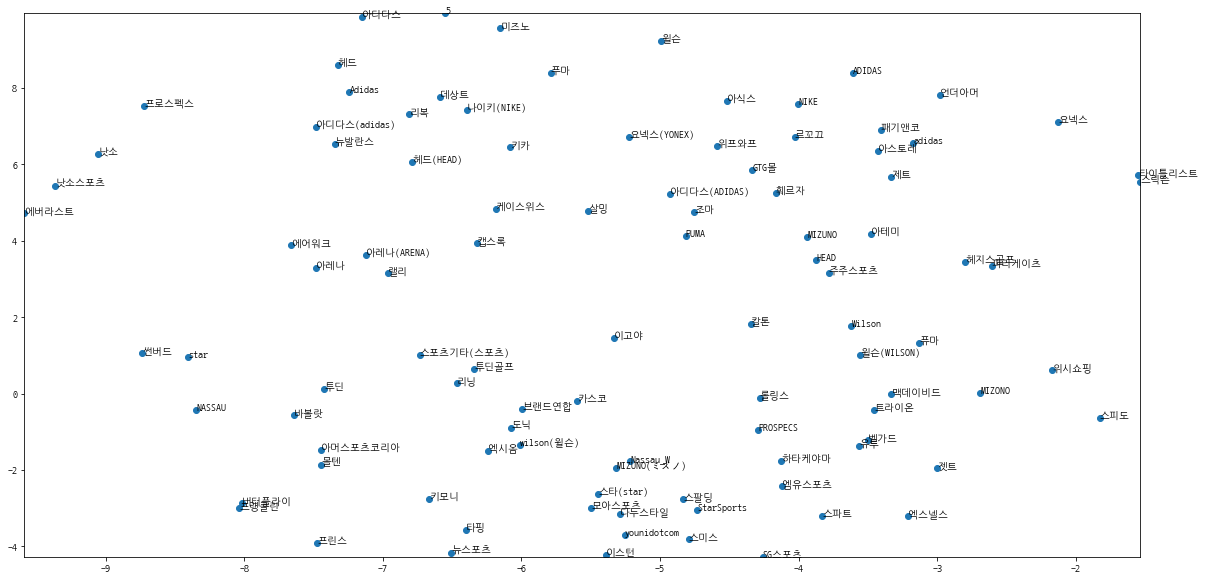

In [67]:
display_closestwords_tsnescatterplot(model, "5", top_n=100)

/root/no-error/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/root/no-error/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/root/no-error/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


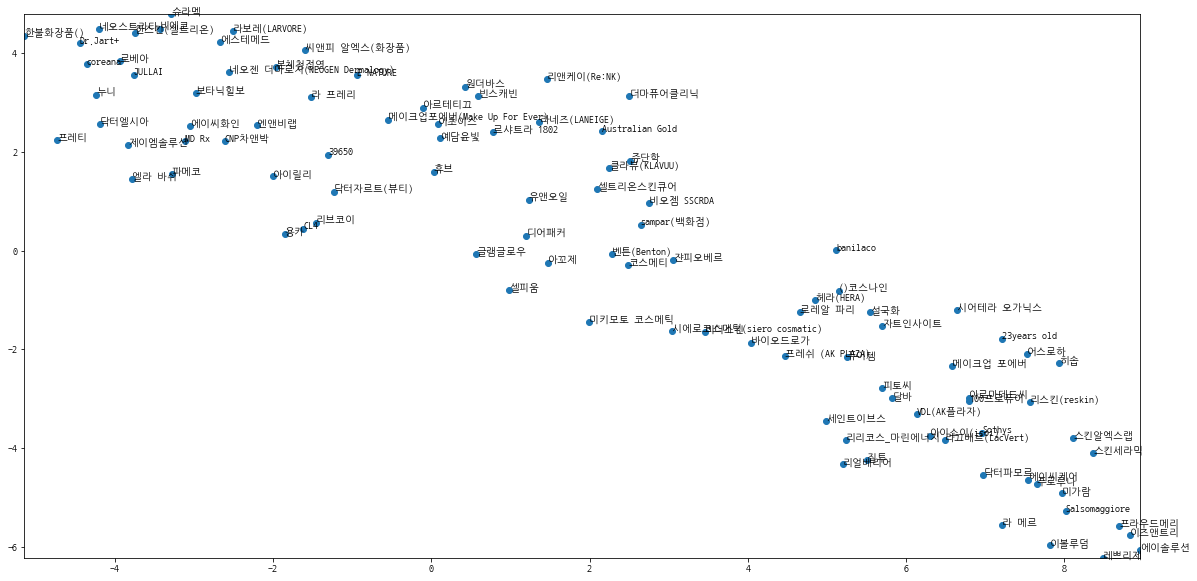

In [68]:
display_closestwords_tsnescatterplot(model, "39650", top_n=100)

#### apply test

In [3]:
%matplotlib inline

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import gensim
import re

data_path = "/workspace/dataset/"

In [4]:
model = gensim.models.Word2Vec.load("b2v.model")

In [5]:
df = pd.read_csv(data_path + "train_sample.csv")
print(df.shape)
df.head()

(8134818, 11)


,bcateid,brand,dcateid,maker,mcateid,model,pid,price,product,scateid,updttm
0,1,퍼즐라이프,-1,상품상세설명 참조,1,퍼즐라이프 직소퍼즐 바다거북의 여행,b'O4486751463',16520,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),2,b'20180227091029'
1,3,바보사랑,-1,MORY|해당없음,3,아이폰6S/6S+ tree farm101 - 다이어리케이스|아이폰6S/6S+,b'P3307178849',20370,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][...,4,b'20180429085019'
2,5,크리비아,-1,NaN,5,크리비아 기모 3부 속바지 GLG4314P,b'R4424255515',-1,크리비아 기모 3부 속바지 GLG4314P,6,b'20180426102314'
3,7,잭앤질,-1,㈜크리스패션,7,[잭앤질] 남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,b'F3334315393',16280,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,8,b'20180422084512'
4,10,NaN,-1,기타,9,SD코드프리혈당시험지[50매],b'N731678492',-1,코드프리혈당시험지50매/코드프리시험지/최장유효기간,11,b'20180424071623'


In [6]:
valid_tag_dict_path = "b2v_dict.pickle"
valid_tag_dict = pickle.load(open(valid_tag_dict_path, 'rb'))
exception_word_list = ["참조", "없음", "표기", "별도", "상세", "자체", "불명", "미입력", "공개불가"]
exception_tag_list = ["기타", "", "."]

def check_valid_keyword(keyword):
    if keyword is np.nan:
        return False
    else:
        if any(exception in keyword for exception in exception_word_list):
            return False
        elif keyword in exception_tag_list:
            return False
        else:
            return True

def get_encoded_tag(key):
    if key in valid_tag_dict:
        return valid_tag_dict[key]
    else:
        return valid_tag_dict["-1"]

def get_trimed_tag(brand, maker):
    brand_valid = check_valid_keyword(brand)
    maker_valid = check_valid_keyword(maker)
    if brand_valid:
        return get_encoded_tag(brand)
    else:
        if maker_valid:
            return get_encoded_tag(brand)
    return valid_tag_dict["-1"]

In [7]:
df['tag'] = df.apply(lambda x: get_trimed_tag(x['brand'], x['maker']), axis=1)

In [8]:
df = df[['tag']]
df['tag'] = df['tag'].apply(lambda x: str(x))

In [9]:
df.head(5)

,tag
0,701
1,2
2,615
3,328
4,1


In [10]:
def get_b2v(tag, vec_size):
    if tag in model.wv.vocab:
        return model.wv[tag]
    else:
        return np.zeros(vec_size)

In [11]:
df['b2v'] = df['tag'].apply(lambda x: get_b2v(x, 200))

In [12]:
df.head(5)

,tag,b2v
0,701,"[0.19656007, 0.23100145, 0.080925904, -0.04694..."
1,2,"[-1.1729219, -0.26402617, -0.19475669, 0.44119..."
2,615,"[0.07443856, 0.055406377, -0.271245, 0.0264297..."
3,328,"[0.07836264, 0.2185042, -0.4266105, 0.15860552..."
4,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
